In [20]:
from os.path import join, splitext
from os import listdir, readlink
from collections import OrderedDict

import ijroi
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
MODEL_DIR = 'models'
MODEL_FILE = join(MODEL_DIR, 'simple_localizer.h5')
IJ_ROI_DIR = join('data1', 'bounding_boxes_299')


HEIGHT, WIDTH = 299, 299

CLASSES = ['Type_1', 'Type_2', 'Type_3']
TRAINING_DIR = join('data1', 'train_299')

In [408]:
def _get_dict_roi():
    d = OrderedDict()
    for f in listdir(IJ_ROI_DIR):
        d[splitext(f)[0]] = join(IJ_ROI_DIR, f)
    return d


def _get_dict_all_images():
    d = OrderedDict()
    for class_ in CLASSES:
        for f in listdir(join(TRAINING_DIR, class_)):
            img_id = splitext(f)[0]
            d[img_id] = join(TRAINING_DIR, class_, f)
    return d


def _get_dict_tagged_images():
    all_images, tagged_roi = _get_dict_all_images(), _get_dict_roi()
    d = OrderedDict()
    for img_id in all_images:
        if img_id in tagged_roi:
            d[img_id] = all_images[img_id]
    return d


def _get_dict_untagged_images():
    d = _get_dict_all_images()
    for img_id in _get_dict_tagged_images():
        del d[img_id]
    return d


def _convert_from_roi(fname):
    """Convert a roi file to a numpy array [x, y, h, w].

    Parameters
    ----------
    fname : string
        If ends with `.roi`, we assume a full path is given

    """
    if not fname.endswith('.roi'):
        fname = '%s.roi' % join(IJ_ROI_DIR, fname)

    with open(fname, 'rb') as f:
        roi = ijroi.read_roi(f)
        top, left = roi[0]
        bottom, right = roi[2]
        height, width = bottom - top, right - left

        return np.array([top, left, height, width])


def _get_tagged_images():
    """Read images, tags and labels for any images that have been tagged.

    Return
    ------
    labels : array
    X : np.array
        Images
    Y : np.array
        Bounding boxes in format [y, x, h, w]

    """
    roi_dict, img_dict = _get_dict_roi(), _get_dict_tagged_images()
    # Initialize X and Y (contains 4 values x, y, w, h)
    X = np.zeros((len(img_dict), HEIGHT, WIDTH, 3))
    Y = np.zeros((len(img_dict), 4))
    # Load the image files into a nice data array
    for idx, key in enumerate(img_dict):
        img = load_img(img_dict[key], target_size=(HEIGHT, WIDTH))
        X[idx] = img_to_array(img)
        Y[idx] = _convert_from_roi(roi_dict[key])

    return list(img_dict.keys()), X, Y


def _load_images(fnames):
    X = np.zeros((len(fnames), HEIGHT, WIDTH, 3))
    for idx, fname in enumerate(fnames):
        X[idx] = load_img(join(TRAINING_DIR, fname))
    return fnames, X


def _get_untagged_images():
    img_dict = _get_dict_untagged_images()
    X = np.zeros((len(img_dict), HEIGHT, WIDTH, 3))
    for idx, img_id in enumerate(img_dict):
        X[idx] = load_img(img_dict[img_id])
    return list(img_dict.keys()), X


def _get_all_images():
    img_dict = _get_dict_all_images()
    X = np.zeros((len(img_dict), HEIGHT, WIDTH, 3))
    for idx, img_id in enumerate(img_dict):
        X[idx] = load_img(img_dict[img_id])
    return list(img_dict.keys()), X

In [409]:
labels, X, Y = _get_tagged_images()
print(labels[:20])

['230', '1281', '1136', '35', '10', '14', '1013', '1393', '308', '342', '1131', '1430', '1161', '208', '1105', '1226', '142', '294', '384', '254']


0 0 299 299


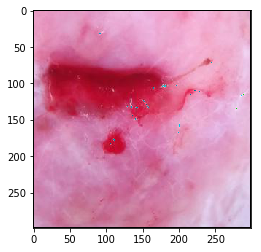

In [356]:
index = labels[18]

y, x, h, w = _convert_from_roi(index)
print(x, y, x+w, y+h)

idx = labels.index(index)
img = np.copy(X[idx])
img = np.abs(img - 255)

img[y, x:x+w] = 255
img[y+h-1, x:x+w] = 255
img[y:y+h, x] = 255
img[y:y+h, x+w-1] = 255

plt.imshow(img)

In [411]:
labels, X = _get_all_images()
predictions = np.load(join('src', 'predictions.npy'))
print(X.shape)
print(predictions.shape)

(1332, 299, 299, 3)
(1332, 4)


In [430]:
unlabelled_labels = _get_untagged_images()[0]
print(unlabelled_labels[:100])

['889', '779', '817', '814', '928', '685', '732', '513', '663', '653', '725', '855', '596', '532', '842', '787', '641', '901', '769', '48', '550', '645', '991', '965', '649', '619', '918', '821', '539', '497', '809', '833', '523', '895', '531', '1339', '667', '846', '478', '484', '677', '624', '643', '536', '972', '623', '977', '578', '81', '713', '891', '96', '518', '764', '873', '763', '727', '802', '879', '55', '620', '759', '751', '7', '683', '805', '560', '709', '579', '516', '998', '930', '836', '576', '481', '558', '582', '921', '880', '553', '668', '660', '739', '917', '783', '583', '984', '982', '745', '562', '765', '906', '887', '551', '580', '939', '795', '398', '411', '816']


298 21 140 178


/mnt/nfs/ppolicar/cervix-classif/env/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in ushort_scalars


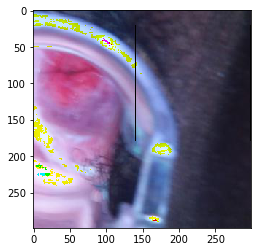

In [443]:
index = labels.index('641')

img = np.copy(X[index])
img = np.abs(img - 255)

y, x, h, w = np.rint(predictions[index]).astype(np.uint16)
y2, x2 = y + h, x + w

x = min(x, 298)
y = min(y, 298)
x2 = min(x2, 298)
y2 = min(y2, 298)
print(x, y, x2, y2)

img[y, x:x2+1] = 255
img[y2, x:x2+1] = 255
img[y:y2+1, x] = 255
img[y:y2+1, x2] = 255

plt.imshow(img)